<a href="https://colab.research.google.com/github/renaud-florquin/hands_on_AI/blob/master/D%C3%A9fis%20en%20intelligence%20artificielle/D%C3%A9fi1%20-%20IA%20et%20analyse%20images/FireForest_training.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Fire Forest Detection

## Google drive connection

Initialize google drive to save the results

In [0]:
from google.colab import drive

In [0]:
from collections import OrderedDict
import json
import time

In [42]:
drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


In [0]:
!rm -rf results
!rm -rf big
!rm -rf test_images_with_classes.tar
!rm -rf test_images_with_classes
!rm -rf forest_big.tar
!mkdir results

## Meta parameters

In [0]:
meta_params = {
  'config_id': 'Big_Xception_no_freeze_Adagrad_1024_512_128',
  'categories': ['fire', 'no_fire', 'start_fire'],
  'epochs': 100,
  'batch_size': 50,
  'resolution': 224,
  'train_generator': {
     'with_data_augmentation': True,
     'rotation_range': 15,
     'width_shift_range': 0.1,
     'height_shift_range': 0.1,
     'shear_range': 0.1,
     'horizontal_flip': True,
     'zoom_range': 0.1,
  },
  'base_model': 'Xception',
  'trainable_layers': 1,
  'optimizer': 'Adagrad',
  'classifier_topology': [
      {
          'nbr_nodes': 1024,
          'activation': 'relu',
          'dropout': 0.4,
      },                        
      {
          'nbr_nodes': 512,
          'activation': 'relu',
          'dropout': 0.4,
      },                        
      {
          'nbr_nodes': 128,
          'activation': 'relu',
          'dropout': 0,
       }                        
  ],
}

In [0]:
results = OrderedDict()

## Data loading and preparation

In [0]:
!cp gdrive/My\ Drive/UMons.ai/forest_big.tar .

In [8]:
!tar -xvf forest_big.tar

big/
big/train/
big/validation/
big/validation/fire/
big/validation/no_fire/
big/validation/start_fire/
big/validation/start_fire/._from_rfl__90.jpeg
big/validation/start_fire/from_rfl__90.jpeg
big/validation/start_fire/from_rfl__736.jpeg
big/validation/start_fire/from_rfl__274.jpeg
big/validation/start_fire/from_rfl__331.jpeg
big/validation/start_fire/from_rfl__761.jpeg
big/validation/start_fire/from_rfl__258.jpeg
big/validation/start_fire/._from_rfl__45.jpeg
big/validation/start_fire/from_rfl__45.jpeg
big/validation/start_fire/from_rfl__399 (1).jpeg
big/validation/start_fire/from_rfl__281.jpeg
big/validation/start_fire/from_rfl__405.jpeg
big/validation/start_fire/from_rfl__686.jpeg
big/validation/start_fire/from_rfl__556.jpeg
big/validation/start_fire/from_rfl__278.jpeg
big/validation/start_fire/from_rfl__595.jpeg
big/validation/start_fire/._from_rfl__49.jpeg
big/validation/start_fire/from_rfl__49.jpeg
big/validation/start_fire/from_rfl__407 (1).jpeg
big/validation/start_fire/from_rf

Issue with file name starting with a '.' character => remove from repo

In [0]:
!find big -name '\.*.jpeg' -exec rm {} \;

In [0]:
import os
import math
import shutil
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split

Create directory structure for tensorflow generator

## Data generator

In [0]:
import tensorflow as tf

In [0]:
train_dir = os.path.join('big', 'train')
validation_dir = os.path.join('big', 'validation')

In [13]:
# All images will be rescaled by 1./255.
if meta_params['train_generator']['with_data_augmentation']:
    train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
      rescale=1./255,
      rotation_range=meta_params['train_generator']['rotation_range'],
      width_shift_range=meta_params['train_generator']['width_shift_range'],
      height_shift_range=meta_params['train_generator']['height_shift_range'],
      shear_range=meta_params['train_generator']['shear_range'],
      zoom_range=meta_params['train_generator']['zoom_range'],
      horizontal_flip=meta_params['train_generator']['horizontal_flip'],
      fill_mode='nearest')
else:
    train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
      rescale=1./255)

test_datagen  = tf.keras.preprocessing.image.ImageDataGenerator( rescale = 1.0/255. )

# Flow training images in batches of 20 using train_datagen generator
train_generator = train_datagen.flow_from_directory(train_dir,
                                                   batch_size=meta_params['batch_size'],
                                                   class_mode='categorical',
                                                   target_size=(meta_params['resolution'], meta_params['resolution']))    
# Flow validation images in batches of 20 using test_datagen generator
validation_generator =  test_datagen.flow_from_directory(validation_dir,
                                                        batch_size=meta_params['batch_size'],
                                                        class_mode  = 'categorical',
                                                        target_size = (meta_params['resolution'], meta_params['resolution']))


Found 3295 images belonging to 3 classes.
Found 1099 images belonging to 3 classes.


Display training images

In [0]:
x_step, y_step = train_generator.next()

In [15]:
x_step.shape

(50, 224, 224, 3)

In [0]:
assert x_step.shape[0] == meta_params['batch_size']
assert x_step.shape[1] == meta_params['resolution']
assert x_step.shape[2] == meta_params['resolution']
assert x_step.shape[3] == 3

/usr/local/lib/python3.6/dist-packages/matplotlib/text.py:1191: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


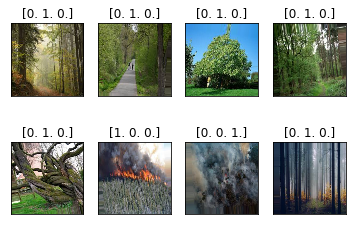

In [17]:
img_rows = 2
img_columns = 4
amount = img_rows * img_columns
fig = plt.figure()

for i in range(amount):
    ax = fig.add_subplot(img_rows, img_columns, 1 + i)
    plt.imshow(x_step[i])
    plt.title(y_step[i])
    plt.xticks([]) 
    plt.yticks([])

plt.show()

## Transfer learning

In [18]:
base_model = getattr(tf.keras.applications, meta_params['base_model'])
base_model = base_model(include_top=False, weights='imagenet', input_shape=(meta_params['resolution'],meta_params['resolution'],3))

for layer in base_model.layers:
    layer.trainable = False

if meta_params['trainable_layers']: 
    for layer in base_model.layers[meta_params['trainable_layers']:]:
        layer.trainable = True

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


## Create a custom top classifier

In [0]:
x = base_model.output
x = tf.keras.layers.GlobalAveragePooling2D()(x)

for layer_topology in meta_params['classifier_topology']:
    x = tf.keras.layers.Dense(layer_topology['nbr_nodes'], activation=layer_topology['activation'])(x)
    if layer_topology['dropout']:
        x = tf.keras.layers.Dropout(rate=layer_topology['dropout'])(x)

predictions = tf.keras.layers.Dense(len(meta_params['categories']), activation='softmax')(x)
model = tf.keras.models.Model(inputs=base_model.inputs, outputs=predictions)

In [20]:
results['model'] = OrderedDict()
results['model']['summary'] = []
summary = []
model.summary(print_fn=lambda info: summary.append(info))
results['model']['summary'] = '\n'.join(summary)
print(results['model']['summary'])

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 111, 111, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, 111, 111, 32) 128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, 111, 111, 32) 0           block1_conv1_bn[0][0]            
______________________________________________________________________________________________

In [0]:
model.compile(loss='categorical_crossentropy', optimizer=meta_params['optimizer'], metrics=['accuracy'])

In [22]:
results['training'] = OrderedDict()
results['training']['train_steps_per_epoch'] = len(train_generator)
results['training']['validation_steps_per_epoch'] = len(validation_generator)
results['training']

OrderedDict([('train_steps_per_epoch', 66),
             ('validation_steps_per_epoch', 22)])

In [38]:
meta_params['epochs']

30

In [0]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, verbose=0, mode='min')
model_saver = tf.keras.callbacks.ModelCheckpoint('results', save_best_only=True, monitor='val_loss', mode='min')
csv_logger = tf.keras.callbacks.CSVLogger('results/training.log')

In [24]:
t1 = time.time()
history = model.fit_generator(
    train_generator,
    epochs=meta_params['epochs'],
    validation_data=validation_generator,
    callbacks=[early_stopping, model_saver, csv_logger]
    )
t2 = time.time()
results['training']['duration'] = t2 - t1

Epoch 1/30
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
66/66 [==============================] - 179s 3s/step - loss: 0.3181 - acc: 0.8841 - val_loss: 0.2243 - val_acc: 0.9290
Epoch 2/30
66/66 [==============================] - 153s 2s/step - loss: 0.0907 - acc: 0.9700 - val_loss: 0.1515 - val_acc: 0.9418
Epoch 3/30
66/66 [==============================] - 153s 2s/step - loss: 0.0593 - acc: 0.9803 - val_loss: 0.1219 - val_acc: 0.9600
Epoch 4/30
66/66 [==============================] - 153s 2s/step - loss: 0.0483 - acc: 0.9845 - val_loss: 0.1231 - val_acc: 0.9645
Epoch 5/30
66/66 [==============================] - 153s 2s/step - loss: 0.0381 - acc: 0.9845 - val_loss: 0.1297 - val_acc: 0.9636
Epoch 6/30
66/66 [==============================] - 153s 2s/step - loss: 0.0305 - acc: 0.9866 - val_loss: 0.1286 - val_acc: 0.9654
Epoch 7/30
66/66 [==============================] - 153s 2s/step - loss: 0.0338 - acc: 0.9869 - 

In [0]:
# Save the model
model.save('results/model.h5')

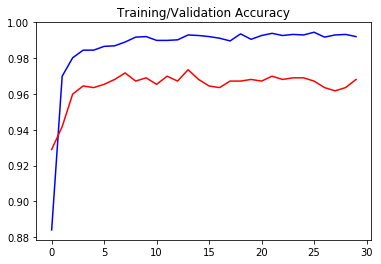

In [26]:
acc = history.history['acc']
val_acc = history.history['val_acc']
epochs   = range(len(acc)) # Get number of epochs
results['training']['history'] = OrderedDict()
results['training']['history']['epochs'] = list(epochs)
results['training']['history']['acc'] = [float(x) for x in acc]
results['training']['history']['val_acc'] = [float(x) for x in val_acc]

plt.plot(epochs, acc, 'b')
plt.plot(epochs, val_acc, 'r')
plt.title('Training/Validation Accuracy')

plt.savefig('results/training_accuracy.png')

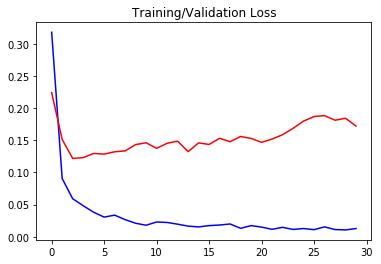

In [27]:
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs   = range(len(acc)) # Get number of epochs
results['training']['history']['loss'] = [float(x) for x in loss]
results['training']['history']['val_loss'] = [float(x) for x in val_loss]

plt.plot(epochs, loss, 'b')
plt.plot(epochs, val_loss, 'r')
plt.title('Training/Validation Loss')

plt.savefig('results/training_loss.png')

## Dump the data to Google Drive

In [28]:
drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


In [0]:
with open('results/meta_parameters.json', 'w') as f:
  json.dump(meta_params, f)
with open('results/results.json', 'w') as f:
  json.dump(results, f)  

In [30]:
shutil.move('results', 'gdrive/My Drive/UMons.ai/{}'.format(meta_params['config_id']))

'gdrive/My Drive/UMons.ai/Big_Xception_no_freeze_Adagrad_1024_128'

# Evaluation using test images

In [0]:
!rm -Rf test
!mkdir test

In [0]:
!cp gdrive/My\ Drive/UMons.ai/test_images_with_classes.tar .

In [33]:
!tar -xvf test_images_with_classes.tar

._test_images_with_classes
test_images_with_classes/
test_images_with_classes/._.DS_Store
test_images_with_classes/.DS_Store
test_images_with_classes/fire/
test_images_with_classes/no_fire/
test_images_with_classes/start_fire/
test_images_with_classes/start_fire/._test15.jpg
test_images_with_classes/start_fire/test15.jpg
test_images_with_classes/start_fire/._test28.jpg
test_images_with_classes/start_fire/test28.jpg
test_images_with_classes/start_fire/._test14.jpg
test_images_with_classes/start_fire/test14.jpg
test_images_with_classes/start_fire/._test16.jpg
test_images_with_classes/start_fire/test16.jpg
test_images_with_classes/start_fire/._.DS_Store
test_images_with_classes/start_fire/.DS_Store
test_images_with_classes/start_fire/._test13.jpg
test_images_with_classes/start_fire/test13.jpg
test_images_with_classes/start_fire/._test76.jpg
test_images_with_classes/start_fire/test76.jpg
test_images_with_classes/start_fire/._test63.jpg
test_images_with_classes/start_fire/test63.jpg
test_im

In [0]:
!find test_images_with_classes -name '\.*.jpg' -exec rm {} \;

In [35]:
test_dir = os.path.join('test_images_with_classes')

test_datagen  = tf.keras.preprocessing.image.ImageDataGenerator( rescale = 1.0/255. )

test_generator =  test_datagen.flow_from_directory(test_dir,
                                                        batch_size=meta_params['batch_size'],
                                                        class_mode  = 'categorical',
                                                        target_size = (meta_params['resolution'], meta_params['resolution']))


Found 100 images belonging to 3 classes.


In [36]:
prediction = model.evaluate_generator(test_generator, verbose=1)


2/2 [==============================] - 1s 633ms/step - loss: 0.1384 - acc: 0.9700


In [37]:
prediction

[0.13844379037618637, 0.97]